In [1]:
# Instalar biblioteca watermark para visualização de ambiente e versões de pacotes foram usados no projeto
# %pip install -q -U watermark

In [2]:
# %pip install-q -U pingouin

In [3]:
# Importar bibliotecas
from datetime import datetime

import pandas as pd
import numpy as np
from scipy import stats # para teste de normal (Person e Shapiro)
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from IPython.display import display
import warnings

pd.set_option('future.no_silent_downcasting', True)

# Ignorar avisos que podem ocorrer durante o ajuste de algumas distribuições
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Teste de Homogeneidade de Variâncias

* O objetivo principal é garantir que os testes que você vai usar para comparar as médias de diferentes grupos sejam confiáveis, válidos e justos.

**Objetivo Técnico** - o objetivo é verificar se a suposição de homogeneidade das variâncias é atendida. Esta é uma condição necessária para usar corretamente testes estatísticos que comparam as médias de dois ou mais grupos, como:

* **Teste t de Student (para 2 grupos)**
* **ANOVA - Análise de Variância (para 3 ou mais grupos)**

**Por que isso é tão importante?**
Esses testes funcionam calculando uma "variância agrupada" (pooled variance) para medir o erro aleatório geral. Eles assumem que a variabilidade dentro de cada grupo é aproximadamente a mesma.

* **Se a suposição é atendida (as variâncias são homogêneas)**: O teste é preciso. O p-valor que ele calcula é confiável, e você pode ter certeza da sua conclusão sobre as médias.

* **Se a suposição é violada (as variâncias são heterogêneas)**: O teste se torna não confiável. Ele tem uma probabilidade maior de cometer um Erro Tipo I, ou seja, **encontrar uma diferença estatisticamente significativa entre as médias que, na verdade, não existe (um falso positivo)**.

**Como Avaliar a Homogeneidade das Variâncias?**
    
 Usa-se um teste estatístico específico para isso. Os mais comuns são:

* **Teste de Levene**: O mais recomendado, pois não exige que os dados sigam uma distribuição normal.

* **Teste de Bartlett**: Exige que os dados de cada grupo sejam normalmente distribuídos.

**Interpretação desses testes:**

* **Hipótese Nula (H₀)**: As variâncias dos grupos são iguais (homogêneas).

* Se o **p-valor > 0.05**: Ótimo! Não rejeitamos a hipótese nula. A suposição foi atendida e você pode prosseguir com seu **teste ANOVA ou t-test padrão**.

* Se o **p-valor < 0.05**: Atenção! A suposição foi violada. Você não deve usar um ANOVA ou t-test padrão. Em vez disso, você deve usar uma versão alternativa, como a **ANOVA de Welch ou o t-test de Welch**, que não exigem essa suposição.

In [4]:
# Carregar base de dados
df=pd.read_csv("heart_disease_uci_tratado_3.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    bool   
 8   restecg   920 non-null    object 
 9   thalch    920 non-null    float64
 10  exang     920 non-null    bool   
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    object 
 13  num       920 non-null    int64  
 14  num_reag  920 non-null    int64  
dtypes: bool(2), float64(4), int64(4), object(5)
memory usage: 95.4+ KB


### **Teste de Levene**
O **teste de Levene** avalia se diferentes grupos nos seus dados possuem variâncias homogêneas, um pressuposto de muitos testes estatísticos paramétricos.

#### **Hipóteses do teste**:

* **H₀**: Os grupos têm variâncias iguais (homogênas)

* **H₁**: Os grupos têm variâncias diferentes (heterogenêas)

**Interpretação:**

* **p-valor < 0,05**: Rejeitamos H₀ - as variâncias são significativamente diferentes

* **p-valor > 0,05**: Não rejeitamos H₀ - as variâncias são homogênea

### Identificando variáveis

In [6]:
# Selecionar colunas numéricas (qualquer tipo de número, int ou float)
colunas_numericas = df.select_dtypes(include=np.number).columns.tolist()
print("COLUNAS NUMÉRICAS:", colunas_numericas)

COLUNAS NUMÉRICAS: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num', 'num_reag']


In [7]:
# Selecionar colunas categóricas (texto/object ou booleano)
colunas_categoricas = df.select_dtypes(include=['object', 'bool']).columns.tolist()
print("COLUNAS CATEGÓRICAS:", colunas_categoricas)

COLUNAS CATEGÓRICAS: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope']


In [8]:
# Definindo as colunas numéricas e categóricas que seram testadas
colunas_numericas = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
colunas_categoricas = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'num_reag']

In [9]:
# Função para testar homegeneidade de variancias - com teste Levene
def analisar_homogeneidade_variancias(df, colunas_numericas, colunas_categoricas):
    """
    Realiza o Teste de Levene para todas as combinações de colunas numéricas e categóricas,
    e retorna um DataFrame com os resultados e interpretações.
    """
    resultados = []

    # Loop pelas combinações
    for cat in colunas_categoricas:
        for num in colunas_numericas:
            # Cria uma lista de arrays, onde cada array contém os dados de um grupo
            grupos = [
                grupo[num].dropna() for _, grupo in df.groupby(cat) if not grupo.empty
            ]
            
            # O teste precisa de pelo menos 2 grupos para ser executado
            if len(grupos) > 1:
                try:
                    stat, p = stats.levene(*grupos)
                    resultados.append({
                        "Variável Numérica": num,
                        "Variável Categórica": cat,
                        "Levene_Stat": stat,
                        "p_valor": p
                    })
                except ValueError:
                    # Pula combinações onde um grupo não tem dados suficientes
                    continue
    
    if not resultados:
        print("Nenhum teste pôde ser executado.")
        return pd.DataFrame()

    df_resultados = pd.DataFrame(resultados)

    # --- ADICIONANDO A INTERPRETAÇÃO DIRETA NO DATAFRAME ---
    condicao_rejeita_h0 = df_resultados['p_valor'] <= 0.05
    texto_rejeita = "Rejeita H₀ (Variâncias Diferentes)"
    texto_nao_rejeita = "Não Rejeita H₀ (Variâncias Semelhantes)"
    
    df_resultados['Interpretação'] = np.where(condicao_rejeita_h0, texto_rejeita, texto_nao_rejeita)
    
    return df_resultados.sort_values("p_valor")

def style_levene_results(df):
    """Aplica formatação condicional para destacar resultados importantes."""
    def highlight_significant(row):
        return ['background-color: #FFDDDD'] * len(row) if row['p_valor'] <= 0.05 else [''] * len(row)
    
    return df.style.apply(highlight_significant, axis=1)\
                   .format({'Levene_Stat': '{:.2f}', 'p_valor': '{:.4f}'})

In [10]:
# Chamar a função
df_levene = analisar_homogeneidade_variancias(df, colunas_numericas, colunas_categoricas)

In [11]:
# APRESENTAÇÃO DOS RESULTADOS
print("="*60)
print("    Avaliação da Homogeneidade das Variâncias (Teste de Levene)")
print("="*60)
print("Avaliamos se a dispersão de uma variável numérica é a mesma entre os grupos de uma variável categórica.")
print("Lembrete da Hipótese Nula (H₀): As variâncias entre os grupos são iguais.\n")

# Exibir o DataFrame estilizado (funciona melhor em ambientes como Jupyter Notebook/Lab)
display(style_levene_results(df_levene))

    Avaliação da Homogeneidade das Variâncias (Teste de Levene)
Avaliamos se a dispersão de uma variável numérica é a mesma entre os grupos de uma variável categórica.
Lembrete da Hipótese Nula (H₀): As variâncias entre os grupos são iguais.



,Variável Numérica,Variável Categórica,Levene_Stat,p_valor,Interpretação
7,chol,dataset,47.94,0.0000,Rejeita H₀ (Variâncias Diferentes)
39,oldpeak,num_reag,114.38,0.0000,Rejeita H₀ (Variâncias Diferentes)
14,oldpeak,cp,32.15,0.0000,Rejeita H₀ (Variâncias Diferentes)
34,oldpeak,slope,24.77,0.0000,Rejeita H₀ (Variâncias Diferentes)
29,oldpeak,exang,32.54,0.0000,Rejeita H₀ (Variâncias Diferentes)
6,trestbps,dataset,9.65,0.0000,Rejeita H₀ (Variâncias Diferentes)
2,chol,sex,19.06,0.0000,Rejeita H₀ (Variâncias Diferentes)
9,oldpeak,dataset,7.74,0.0000,Rejeita H₀ (Variâncias Diferentes)
26,trestbps,exang,15.00,0.0001,Rejeita H₀ (Variâncias Diferentes)
25,age,exang,12.55,0.0004,Rejeita H₀ (Variâncias Diferentes)


In [12]:
# Exibir um resumo apenas dos casos em que a suposição foi atendida
print("\n" + "="*60)
print("     RESUMO: Casos Onde a Suposição Foi Atendida (p > 0.05)")
print("="*60)
print("Estas são as combinações onde a suposição de variâncias iguais FOI ATENDIDA.")
print("Para estas, testes como ANOVA e t-test padrão são considerados apropriados e confiáveis.")

# A única mudança é no sinal do filtro: de '<=' para '>'
atendidas = df_levene[df_levene['p_valor'] > 0.05]

if atendidas.empty:
    print("\nNenhum par de variáveis atendeu à suposição de homogeneidade de variâncias.")
else:
    # Usamos 'display' aqui também para manter a formatação
    # Exibimos a lista ordenada do p-valor mais alto para o mais baixo (do mais 'seguro' para o limítrofe)
    display(atendidas.sort_values("p_valor", ascending=False)[['Variável Numérica', 'Variável Categórica', 'p_valor', 'Interpretação']])


     RESUMO: Casos Onde a Suposição Foi Atendida (p > 0.05)
Estas são as combinações onde a suposição de variâncias iguais FOI ATENDIDA.
Para estas, testes como ANOVA e t-test padrão são considerados apropriados e confiáveis.


,Variável Numérica,Variável Categórica,p_valor,Interpretação
33,thalch,slope,0.954369,Não Rejeita H₀ (Variâncias Semelhantes)
21,trestbps,restecg,0.945081,Não Rejeita H₀ (Variâncias Semelhantes)
16,trestbps,fbs,0.890239,Não Rejeita H₀ (Variâncias Semelhantes)
27,chol,exang,0.830103,Não Rejeita H₀ (Variâncias Semelhantes)
38,thalch,num_reag,0.717756,Não Rejeita H₀ (Variâncias Semelhantes)
12,chol,cp,0.707197,Não Rejeita H₀ (Variâncias Semelhantes)
0,age,sex,0.682830,Não Rejeita H₀ (Variâncias Semelhantes)
13,thalch,cp,0.435156,Não Rejeita H₀ (Variâncias Semelhantes)
17,chol,fbs,0.295416,Não Rejeita H₀ (Variâncias Semelhantes)
32,chol,slope,0.253784,Não Rejeita H₀ (Variâncias Semelhantes)


In [13]:
# Exibir um resumo apenas dos casos em que a suposição foi violada
print("\n" + "="*60)
print("     RESUMO: Principais Violações da Suposição (p ≤ 0.05)")
print("="*60)
print("Estas são as combinações onde a suposição de variâncias iguais NÃO foi atendida.")
print("Para estas, testes como ANOVA padrão não são recomendados. Use alternativas como a ANOVA de Welch.")

violacoes = df_levene[df_levene['p_valor'] <= 0.05]

if violacoes.empty:
    print("\nNenhuma violação da suposição de homogeneidade de variâncias foi encontrada.")
else:
    # Usamos 'display' aqui também para manter a formatação
    display(violacoes[['Variável Numérica', 'Variável Categórica', 'p_valor', 'Interpretação']])


     RESUMO: Principais Violações da Suposição (p ≤ 0.05)
Estas são as combinações onde a suposição de variâncias iguais NÃO foi atendida.
Para estas, testes como ANOVA padrão não são recomendados. Use alternativas como a ANOVA de Welch.


,Variável Numérica,Variável Categórica,p_valor,Interpretação
7,chol,dataset,8.795243e-29,Rejeita H₀ (Variâncias Diferentes)
39,oldpeak,num_reag,3.072065e-25,Rejeita H₀ (Variâncias Diferentes)
14,oldpeak,cp,9.207189e-20,Rejeita H₀ (Variâncias Diferentes)
34,oldpeak,slope,3.324165e-11,Rejeita H₀ (Variâncias Diferentes)
29,oldpeak,exang,1.575807e-08,Rejeita H₀ (Variâncias Diferentes)
6,trestbps,dataset,2.821677e-06,Rejeita H₀ (Variâncias Diferentes)
2,chol,sex,1.408051e-05,Rejeita H₀ (Variâncias Diferentes)
9,oldpeak,dataset,4.146747e-05,Rejeita H₀ (Variâncias Diferentes)
26,trestbps,exang,1.152623e-04,Rejeita H₀ (Variâncias Diferentes)
25,age,exang,4.168643e-04,Rejeita H₀ (Variâncias Diferentes)


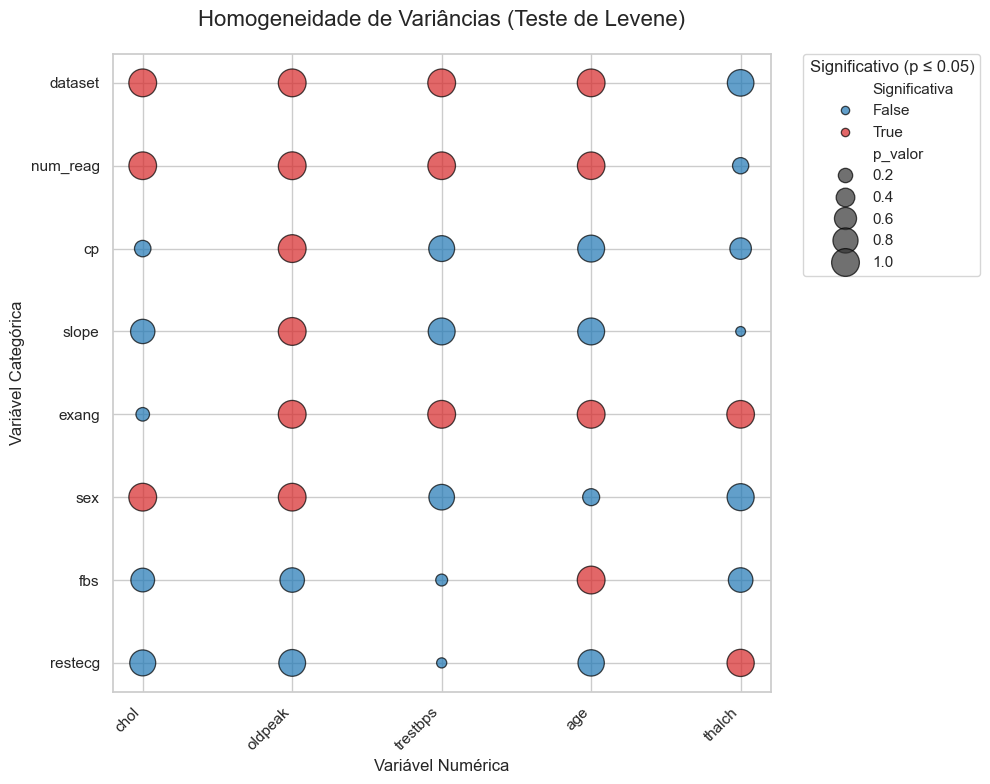

In [14]:
def plotar_levene_scatterplot(df_resultados):
    """
    Cria um gráfico de dispersão aprimorado para visualizar os resultados do Teste de Levene.
    """
    # Definir um tema visual mais limpo para o gráfico
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(12, 8))
    
    # Criar o gráfico
    scatter = sns.scatterplot(
        data=df_resultados,
        x='Variável Numérica',
        y='Variável Categórica',
        # Mapear o tamanho para (1 - p_valor) para que p-valores pequenos resultem em pontos maiores
        size=1 - df_resultados['p_valor'],
        hue='Significativa',
        palette={True: '#d62728', False: '#1f77b4'}, # Vermelho para significativo, azul para não
        sizes=(50, 400), # Ajustar o intervalo de tamanho dos pontos
        alpha=0.7, # Adicionar transparência
        edgecolor='black', # Adicionar borda para melhor definição
        legend='auto'
    )

    # Melhorar o título e os rótulos
    plt.title('Homogeneidade de Variâncias (Teste de Levene)', fontsize=16, pad=20)
    plt.xlabel('Variável Numérica', fontsize=12)
    plt.ylabel('Variável Categórica', fontsize=12)

    # Rotacionar os rótulos do eixo X para evitar sobreposição
    plt.xticks(rotation=45, ha='right')

    # Ajustar a legenda para ficar fora do gráfico
    plt.legend(title='Significativo (p ≤ 0.05)', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Garantir que o layout se ajuste bem com a legenda externa
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    plt.show()

# Aplicar função
alpha = 0.05
df_levene['Significativa'] = df_levene['p_valor'] <= alpha
plotar_levene_scatterplot(df_levene)

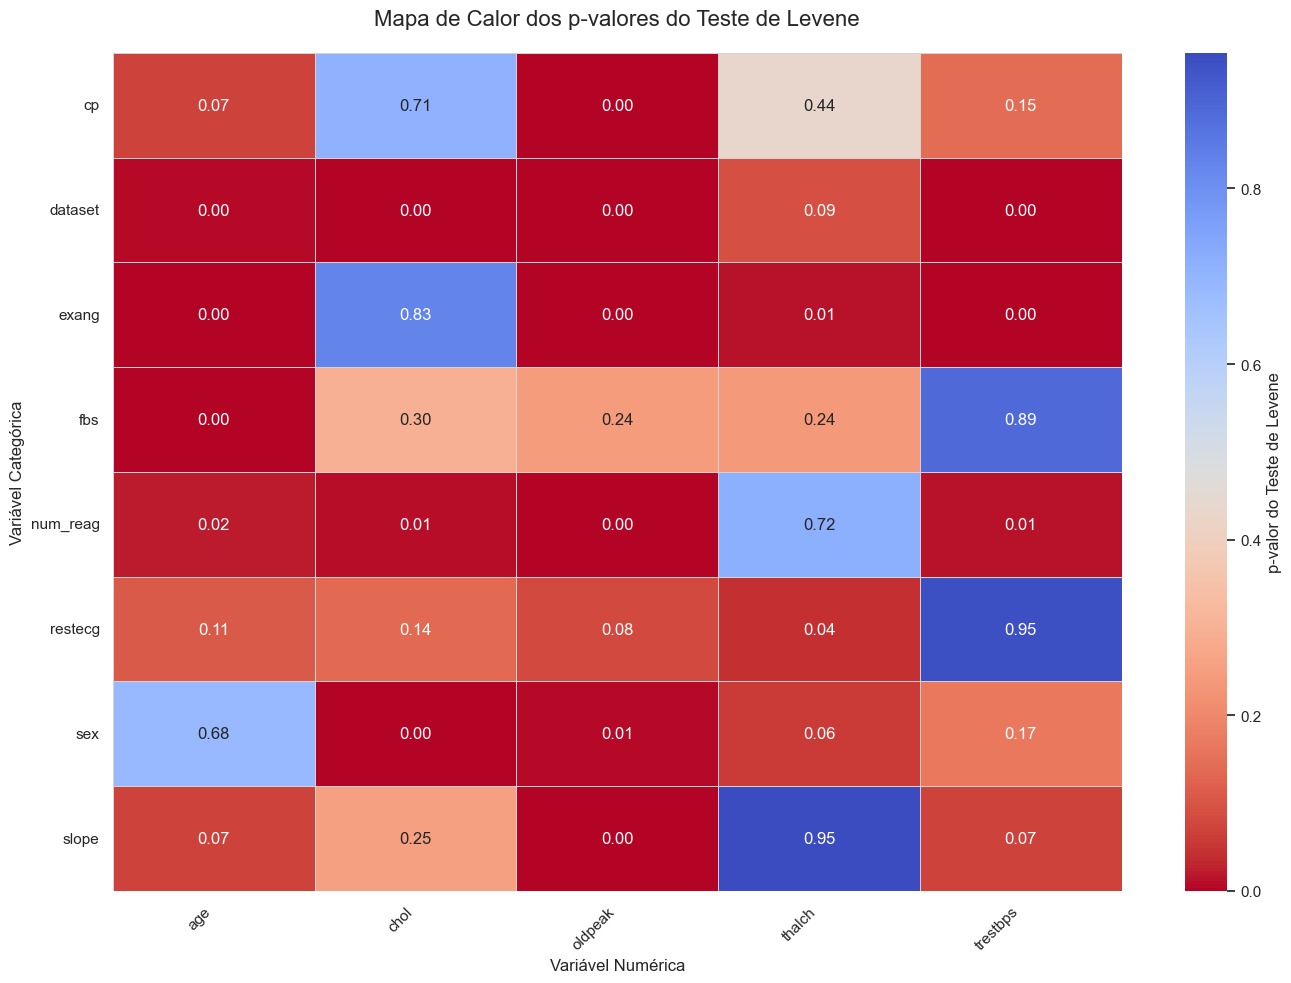

In [15]:
def plotar_levene_heatmap(df_resultados):
    """
    Cria um mapa de calor para visualizar os p-valores do Teste de Levene.
    """
    # Preparar os dados para o heatmap usando uma tabela pivô
    pivot_df = df_resultados.pivot_table(
        index='Variável Categórica', 
        columns='Variável Numérica', 
        values='p_valor'
    )

    plt.figure(figsize=(14, 10))
    
    # Criar o heatmap
    sns.heatmap(
        pivot_df,
        annot=True,          # Exibir os p-valores nas células
        fmt=".2f",           # Formatar os valores com 2 casas decimais
        cmap="coolwarm_r",   # Paleta de cores: vermelho para baixo (ruim), azul para alto (bom)
        linewidths=.5,       # Linhas finas entre as células
        linecolor='lightgray',
        cbar_kws={'label': 'p-valor do Teste de Levene'} # Rótulo da barra de cores
    )

    plt.title('Mapa de Calor dos p-valores do Teste de Levene', fontsize=16, pad=20)
    plt.xlabel('Variável Numérica', fontsize=12)
    plt.ylabel('Variável Categórica', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Aplicar função
plotar_levene_heatmap(df_levene)

## **Principais Conclusões do Relatório**

1. **Violações Frequentes da Homogeneidade**: Um número considerável de combinações de variáveis rejeitou a Hipótese Nula (H₀). Isso significa que, para muitas análises, a suposição de que as variâncias são iguais entre os grupos não é válida. Ignorar isso levaria a conclusões potencialmente incorretas.

2. **oldpeak é a Variável Mais "Problemática"**: A variável numérica oldpeak é a que mais consistentemente apresenta variâncias diferentes entre os grupos. Ela aparece em 6 das combinações que rejeitaram H₀ (num_reag, cp, slope, exang, dataset, sex), indicando que sua dispersão varia muito dependendo da categoria analisada.

3. **chol e trestbps Também Exigem Atenção**: A dispersão do colesterol (chol) e da pressão arterial em repouso (trestbps) também se mostrou diferente dependendo do dataset, sex, exang e num_reag.

4. **Muitos Pares São "Seguros"**: Por outro lado, muitas combinações não rejeitaram H₀ (têm p-valor > 0.05). Para esses pares, a suposição de variâncias homogêneas é válida, e podemos usar os testes estatísticos padrão com confiança. Por exemplo, a relação entre age e sex (p=0.68) é muito segura.

5. **Casos Limítrofes**: A combinação thalch vs. sex (p=0.0583) está muito próxima do limite de 0.05. Embora tecnicamente a suposição seja atendida, é um caso que merece cautela.

## **Qual Teste Aplicar?**
Agora, a parte mais importante: qual teste usar para comparar as médias? 
A sua decisão depende de duas coisas:
1. O resultado do Teste de Levene (se p ≤ 0.05 ou p > 0.05).
2. O número de categorias na sua variável categórica (2 grupos ou 3+ grupos).

| Resultado do Teste de Levene                                   | Nº de Categorias | Próximo Teste Recomendado      | Objetivo                                                      |
|---------------------------------------------------------------|------------------|--------------------------------|--------------------------------------------------------------|
| p-valor ≤ 0.05 (Rejeita H₀ - Variâncias Diferentes)           | 2 Grupos         | ✅ Teste t de Welch             | Comparar as médias de 2 grupos com variâncias diferentes.    |
| p-valor ≤ 0.05 (Rejeita H₀ - Variâncias Diferentes)           | 3 ou mais Grupos | ✅ ANOVA de Welch               | Comparar as médias de 3+ grupos com variâncias diferentes.   |
| p-valor > 0.05 (Não Rejeita H₀ - Variâncias Semelhantes)      | 2 Grupos         | ✅ Teste t de Student (Padrão)  | Comparar as médias de 2 grupos com variâncias semelhantes.   |
| p-valor > 0.05 (Não Rejeita H₀ - Variâncias Semelhantes)      | 3 ou mais Grupos | ✅ ANOVA Padrão                 | Comparar as médias de 3+ grupos com variâncias semelhantes.  |


### **Uso prático**: Test-t e ANOVA

* Na fase exploratória, ajuda a identificar quais variáveis realmente diferem entre pacientes com e sem doença.
* Pode indicar variáveis mais importantes para o modelo, mas não é obrigatório para treinar o modelo.

In [16]:
# Função aplicação dos testes
def executar_analise_de_medias(df_dados, df_levene_resultados):
    """
    Executa o teste de comparação de médias apropriado (t-test/ANOVA, Padrão/Welch)
    para cada par de variáveis, baseado nos resultados do Teste de Levene.

    Retorna um DataFrame com os resultados detalhados.
    """
    resultados_finais = []

    for row in df_levene_resultados.itertuples(index=False):
        var_num = row[0]
        var_cat = row[1]
        p_levene = row[3]
        
        df_filtrado = df_dados[[var_num, var_cat]].dropna()
        n_grupos = df_filtrado[var_cat].nunique()
        
        teste_usado = ""

        if n_grupos >= 2:
            if n_grupos == 2:
                # Para o ttest, precisamos separar os dois grupos de dados manualmente.
                categorias = df_filtrado[var_cat].unique()
                grupo1 = df_filtrado[df_filtrado[var_cat] == categorias[0]][var_num]
                grupo2 = df_filtrado[df_filtrado[var_cat] == categorias[1]][var_num]
                
                # Chamar pg.ttest com os dois grupos como argumentos 'x' e 'y'
                res = pg.ttest(x=grupo1, y=grupo2, correction=(p_levene <= 0.05))
                teste_usado = "Teste t de Welch" if p_levene <= 0.05 else "Teste t de Student"
                
                p_valor_teste = res['p-val'].iloc[0]
                estatistica = res['T'].iloc[0] 
                
            else: # 3 ou mais grupos
                # Para ANOVA, a sintaxe com 'data', 'dv', 'between' está correta.
                if p_levene <= 0.05:
                    res = pg.welch_anova(data=df_filtrado, dv=var_num, between=var_cat)
                    teste_usado = "ANOVA de Welch"
                else:
                    res = pg.anova(data=df_filtrado, dv=var_num, between=var_cat)
                    teste_usado = "ANOVA Padrão"

                p_valor_teste = res['p-unc'].iloc[0]
                estatistica = res['F'].iloc[0]

            resultados_finais.append({
                'Variável Numérica': var_num,
                'Variável Categórica': var_cat,
                'Teste Aplicado': teste_usado,
                'Estatística do Teste': estatistica,
                'p-valor': p_valor_teste
            })

    df_final = pd.DataFrame(resultados_finais)
    df_final['Interpretação'] = df_final['p-valor'].apply(
        lambda p: "Diferença significativa entre as médias" if p <= 0.05 else "Sem diferença significativa"
    )
    return df_final

# Executar a função de análise
df_resultados_finais = executar_analise_de_medias(df, df_levene)

# Exibir a tabela completa 
print("="*70)
print("             Resultados Completos dos Testes de Comparação de Médias")
print("="*70)
# Estilizar a saída para destacar p-valores significativos
display(df_resultados_finais.style.apply(
    lambda row: ['background-color: #FFDDDD'] * len(row) if row['p-valor'] <= 0.05 else [''] * len(row), 
    axis=1
).format({'Estatística do Teste': '{:.2f}', 'p-valor': '{:.4f}'}))

             Resultados Completos dos Testes de Comparação de Médias


,Variável Numérica,Variável Categórica,Teste Aplicado,Estatística do Teste,p-valor,Interpretação
0,chol,dataset,ANOVA de Welch,0.00,1.0000,Sem diferença significativa
1,oldpeak,num_reag,Teste t de Welch,-12.54,0.0000,Diferença significativa entre as médias
2,oldpeak,cp,ANOVA de Welch,47.44,0.0000,Diferença significativa entre as médias
3,oldpeak,slope,ANOVA de Welch,44.61,0.0000,Diferença significativa entre as médias
4,oldpeak,exang,Teste t de Welch,-12.34,0.0000,Diferença significativa entre as médias
5,trestbps,dataset,ANOVA de Welch,0.81,0.4889,Sem diferença significativa
6,chol,sex,Teste t de Welch,-2.72,0.0069,Diferença significativa entre as médias
7,oldpeak,dataset,ANOVA de Welch,15.80,0.0000,Diferença significativa entre as médias
8,trestbps,exang,Teste t de Welch,-4.47,0.0000,Diferença significativa entre as médias
9,age,exang,Teste t de Welch,-5.14,0.0000,Diferença significativa entre as médias


In [17]:
# Apresentar apenas os resultados significativos, ordenados
print("\n" + "="*70)
print("         PRINCIPAIS INSIGHTS: Relações Estatisticamente Significativas")
print("="*70)
print("A tabela abaixo mostra onde a média da variável numérica é ESTATISTICAMENTE DIFERENTE entre os grupos.")

# Filtrar por significância e ordenar pelo p-valor (do mais forte para o mais fraco)
df_insights = df_resultados_finais[df_resultados_finais['p-valor'] <= 0.05].sort_values('p-valor')

if df_insights.empty:
    print("\nNenhuma relação estatisticamente significativa foi encontrada entre as médias dos grupos.")
else:
    display(df_insights.style.format({'Estatística do Teste': '{:.2f}', 'p-valor': '{:.4f}'}))


         PRINCIPAIS INSIGHTS: Relações Estatisticamente Significativas
A tabela abaixo mostra onde a média da variável numérica é ESTATISTICAMENTE DIFERENTE entre os grupos.


,Variável Numérica,Variável Categórica,Teste Aplicado,Estatística do Teste,p-valor,Interpretação
11,age,dataset,ANOVA de Welch,90.73,0.0000,Diferença significativa entre as médias
23,thalch,dataset,ANOVA Padrão,61.40,0.0000,Diferença significativa entre as médias
35,thalch,num_reag,Teste t de Student,12.52,0.0000,Diferença significativa entre as médias
1,oldpeak,num_reag,Teste t de Welch,-12.54,0.0000,Diferença significativa entre as médias
4,oldpeak,exang,Teste t de Welch,-12.34,0.0000,Diferença significativa entre as médias
14,thalch,exang,Teste t de Welch,11.95,0.0000,Diferença significativa entre as médias
32,thalch,cp,ANOVA Padrão,45.90,0.0000,Diferença significativa entre as médias
39,thalch,slope,ANOVA Padrão,55.20,0.0000,Diferença significativa entre as médias
2,oldpeak,cp,ANOVA de Welch,47.44,0.0000,Diferença significativa entre as médias
16,age,num_reag,Teste t de Welch,-8.86,0.0000,Diferença significativa entre as médias


In [18]:
# Carregando a extensão watermark
%reload_ext watermark

In [19]:
# Imprimir
# -a (autor do projeto)
# -v (versões do Python e do IPython)
# -m (informações sobre a máquina (hardware e sistema operacional))
# --iversions (versões de pacotes importadas (import))
agora = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
%watermark -a "Patrick F. R. Ribeiro" -v -m --iversions
print(f"Última atualização: {agora}")

Author: Patrick F. R. Ribeiro

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 8.30.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
pandas    : 2.2.3
scipy     : 1.15.3
pingouin  : 0.5.5
matplotlib: 3.10.0
IPython   : 8.30.0
seaborn   : 0.13.2

Última atualização: 2025-09-20 10:39:59
